<a href="https://colab.research.google.com/github/harry-erskine/PRBX-Travel-Mode-Identification/blob/main/Source%20Code/Decision%20Trees/DT_testing_best_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ML - Decision Trees**

### **Data Preferences**

In [ ]:
### VARIABLES ###

groupSize = 64                   # How many trajectories are represented in each group
motion_points = groupSize - 3    # Do not change this variable

# variables below all 'True' or 'False' (where all 'False' represents the most filtered version of the data)

include_impossible_groups = False      # include groups with trajectories that I have deemed to be invalid
include_stationary_groups = False      # include groups where there is less than 3 meters of total movement
include_airplane_and_boat = False      # include groups where the mode of transportation was 'airplane' or 'boat'
include_all_time_ranges =   False      # include groups where the time between each trajectory is more than 1 second

# include_only_2s_time_range = True

### **Notebook Setup**

In [ ]:
### INSTALLS ###

# !pip install --upgrade gspread
# !pip install pandas
# !pip install scikit-learn

In [ ]:
### IMPORTS ###

import os
from google.colab import drive
import pandas as pd
import numpy as np
import time
#
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
### MOUNT GOOGLE DRIVE ###

mainMountPath = '/content/gdrive'
mainDrivePath = '/content/gdrive/MyDrive/Colab Notebooks/PRBX'

drive.mount(mainMountPath, force_remount=True)

Mounted at /content/gdrive


In [ ]:
### FILE PATHS ###

generatedFilesPath = mainDrivePath + '/Data Files/Generated Files'
cleanedMotionDataPath = generatedFilesPath + '/cleanedMotionDataX' + str(groupSize) + '.csv'

In [ ]:
cmdf = pd.read_csv(cleanedMotionDataPath)
cmdf = cmdf.drop('Unnamed: 0', axis=1)

In [ ]:
# shuffle the dataframe into a random order
df = cmdf.sample(frac=1).reset_index(drop=True)

# remove unwanted data
if include_impossible_groups == False:
  df = df[df['Impossible'] == False]

if include_stationary_groups == False:
  df = df[df['Stationary'] == False]

if include_airplane_and_boat == False:
  df.drop(df[df['Mode'] == 'airplane'].index, inplace=True)
  df.drop(df[df['Mode'] == 'boat'].index, inplace=True)

if include_all_time_ranges == False:
  df = df[df['DT Max'] == 1]

# if include_only_2s_time_range == True:
#   df = df[df['DT Min'] == 2]
#   df = df[df['DT Max'] == 2]

df

,GroupId,UserId,Mode,Old Mode,S0,S1,S2,S3,S4,S5,...,AA RC6,BR RC0,BR RC1,BR RC2,BR RC3,BR RC4,BR RC5,BR RC6,Impossible,Stationary
20,46089,163,train,train,20.885211,21.512884,20.544239,18.766427,19.570781,19.765974,...,1,58,3,0,0,0,0,0,False,False
27,7145,20,bus,bus,15.238655,14.959713,16.092667,16.477411,15.147281,15.252139,...,0,35,6,9,9,1,1,0,False,False
34,8178,20,bike,bike,3.914745,4.417502,3.990792,3.457749,3.864688,3.914746,...,0,37,10,11,3,0,0,0,False,False
36,36633,126,train,train,31.291670,30.952963,29.269380,30.328129,30.179745,29.983473,...,0,61,0,0,0,0,0,0,False,False
51,49194,167,bike,bike,3.779027,4.140112,4.555607,4.140113,4.572394,4.670473,...,4,37,13,11,0,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54680,48174,167,train,train,16.453444,15.852922,16.200923,16.892841,18.961557,16.726629,...,2,56,2,2,1,0,0,0,False,False
54694,50465,167,train,train,37.549910,37.277840,37.109044,37.312289,37.109097,37.446792,...,0,61,0,0,0,0,0,0,False,False
54702,48490,167,train,subway,15.113806,14.708762,14.770854,14.330411,14.098514,15.248662,...,0,61,0,0,0,0,0,0,False,False
54703,8045,20,bike,bike,2.069125,1.566129,1.887522,1.396476,1.796442,2.483236,...,0,19,14,20,7,1,0,0,False,False


In [ ]:
print(df['Mode'].unique())

['train' 'bus' 'bike' 'car' 'walk']


In [ ]:
# Names of raw motion features
raw_speed_features =          [f'S{i}' for i in range(motion_points)]
raw_acceleration_features =   [f'A{i}' for i in range(motion_points)]
raw_jerk_features =           [f'J{i}' for i in range(motion_points)]
raw_alti_velocity_features =  [f'AV{i}' for i in range(motion_points)]
raw_alti_accel_features =     [f'AA{i}' for i in range(motion_points)]
raw_bearing_rate_features =   [f'BR{i}' for i in range(motion_points)]

raw_motion_features = raw_speed_features + raw_acceleration_features + raw_jerk_features + \
                      raw_alti_velocity_features + raw_bearing_rate_features

In [ ]:
# Names of derived motion features
derived_speed_features =          ['S Min', 'S 25% Q', 'S Mean', 'S Median', 'S 75% Q', 'S Max', 'S Range', 'S IQR']
derived_acceleration_features =   ['A Min', 'A 25% Q', 'A Mean', 'A Median', 'A 75% Q', 'A Max', 'A Range', 'A IQR']
derived_jerk_features =           ['J Min', 'J 25% Q', 'J Mean', 'J Median', 'J 75% Q', 'J Max', 'J Range', 'J IQR']
derived_alti_velocity_features =  ['AV Min', 'AV 25% Q', 'AV Mean', 'AV Median', 'AV 75% Q', 'AV Max', 'AV Range', 'AV IQR']
derived_alti_accel_features =     ['AA Min', 'AA 25% Q', 'AA Mean', 'AA Median', 'AA 75% Q', 'AA Max', 'AA Range', 'AA IQR']
derived_bearing_rate_features =   ['BR Min', 'BR 25% Q', 'BR Mean', 'BR Median', 'BR 75% Q', 'BR Max', 'BR Range', 'BR IQR']

# another way of formatting names of derived motion features
min_features =     ['S Min',    'A Min',    'J Min',    'AV Min',    'AA Min',      'BR Min']
q25_features =     ['S 25% Q',  'A 25% Q',  'J 25% Q',  'AV 25% Q',  'AA 25% Q',    'BR 25% Q']
mean_features =    ['S Mean',   'A Mean',   'J Mean',   'AV Mean',   'AA Mean',     'BR Mean']
median_features =  ['S Median', 'A Median', 'J Median', 'AV Median', 'AA Median',   'BR Median']
q75_features =     ['S 75% Q',  'A 75% Q',  'J 75% Q',  'AV 75% Q',  'AA 75% Q',  'BR 75% Q']
max_features =     ['S Max',    'A Max',    'J Max',    'AV Max',    'AA Max',      'BR Max']
range_features =   ['S Range',  'A Range',  'J Range',  'AV Range',  'AA Range',    'BR Range']
iqr_features =     ['S IQR',    'A IQR',    'J IQR',    'AV IQR',    'AA IQR',      'BR IQR']

# derived_motion_features =   derived_speed_features + derived_acceleration_features + derived_jerk_features + \
#                             derived_alti_velocity_features + derived_bearing_rate_features

derived_motion_features =  min_features + mean_features + q75_features + \
                           max_features + range_features + iqr_features

In [ ]:
# Names of range count features
speed_rc_features =         [f'S RC{i}' for i in range(7)]
acceleration_rc_features =  [f'A RC{i}' for i in range(7)]
jerk_rc_features =          [f'J RC{i}' for i in range(7)]
alti_velocity_rc_features = [f'AV RC{i}' for i in range(7)]
alti_accel_rc_features =    [f'AA RC{i}' for i in range(7)]
bearing_rate_rc_features =  [f'BR RC{i}' for i in range(7)]

# Concatenate all range count features
range_counts_features =  speed_rc_features + acceleration_rc_features + jerk_rc_features + \
                        alti_velocity_rc_features + bearing_rate_rc_features

In [ ]:
# Names of all useable features
all_features = raw_motion_features + derived_motion_features + range_counts_features
print(all_features)

['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48', 'S49', 'S50', 'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57', 'S58', 'S59', 'S60', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'J0', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18', 'J19', 'J20', 'J21', 'J22', 'J23', 'J24', 

### **Decision Tree Function**

In [ ]:
def train_and_evaluate_decision_tree(df, features, max_depth):

    # start timer
    start_time = time.time()

    # Extract features and labels
    X = df.loc[:, features].values
    y = df.loc[:, 'Mode']

    # Encoding categorical data
    labelencoder_X = LabelEncoder()
    for i in range(X.shape[1]):
        X[:, i] = labelencoder_X.fit_transform(X[:, i])

    # Factorizing the labels
    y, class_names = pd.factorize(y)

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    # Fitting Classifier to the Training Set
    classifier = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    classifier.fit(X_train, y_train)

    print("This model has a max depth of", max_depth)

    # end timer
    end_time = time.time()
    print("This model took", end_time - start_time, "seconds to train")

    # Model performance on training set
    y_pred_train = classifier.predict(X_train)
    accuracy = metrics.accuracy_score(y_train, y_pred_train)
    print("Training Accuracy: {:.2f}".format(accuracy))
    cm = confusion_matrix(y_train, y_pred_train)

    # Plotting the confusion matrix for the training set
    sns.heatmap(cm, annot=True, cmap='summer', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Training Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(classification_report(y_train, y_pred_train, target_names=class_names))

    # Predicting the test results
    y_pred = classifier.predict(X_test)

    # Classification results on test set
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("\nTest Accuracy: {:.2f}".format(accuracy))
    cm = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix for the test set
    sns.heatmap(cm, annot=True, cmap='summer', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(classification_report(y_test, y_pred, target_names=class_names))

### plot graph of training and testing accuracies

<ipython-input-14-71f699ef555b>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(depth, train, '-ok', color='red', label='Training Data')
<ipython-input-14-71f699ef555b>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(depth, test, '-ok', color='blue', label='Testing Data')


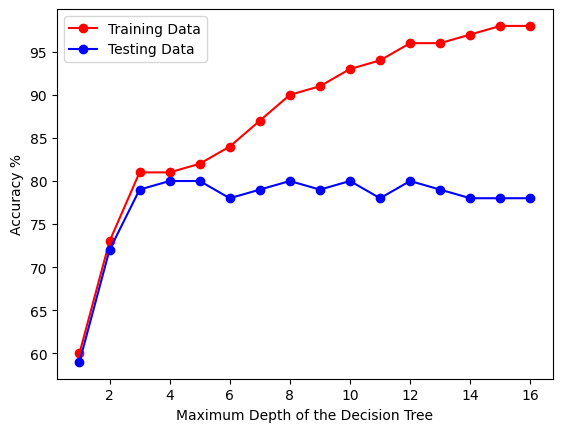

In [ ]:
depth = [1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10, 11, 12, 13, 14, 15, 16]
train = [60, 73, 81, 81, 82, 84, 87, 90, 91, 93, 94, 96, 96, 97, 98, 98]
test =  [59, 72, 79, 80, 80, 78, 79, 80, 79, 80, 78, 80, 79, 78, 78, 78]

plt.plot(depth, train, '-ok', color='red', label='Training Data')
plt.plot(depth, test, '-ok', color='blue', label='Testing Data')
plt.xlabel('Maximum Depth of the Decision Tree')
plt.ylabel('Accuracy %');
plt.legend()
plt.show()

### **Decision Tree - training and testing**

This model has a max depth of 8
This model took 0.4541170597076416 seconds to train
Training Accuracy: 0.89


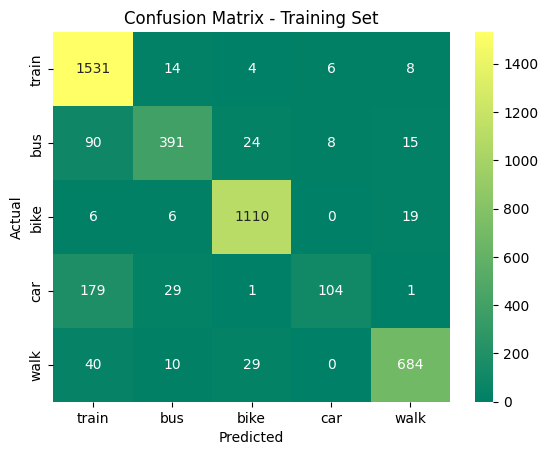

              precision    recall  f1-score   support

       train       0.83      0.98      0.90      1563
         bus       0.87      0.74      0.80       528
        bike       0.95      0.97      0.96      1141
         car       0.88      0.33      0.48       314
        walk       0.94      0.90      0.92       763

    accuracy                           0.89      4309
   macro avg       0.89      0.78      0.81      4309
weighted avg       0.89      0.89      0.88      4309


Test Accuracy: 0.81


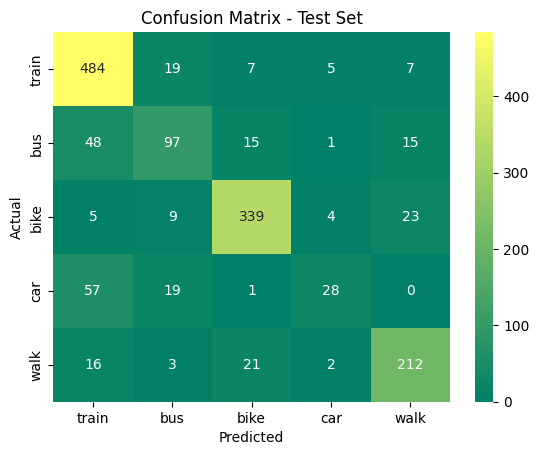

              precision    recall  f1-score   support

       train       0.79      0.93      0.86       522
         bus       0.66      0.55      0.60       176
        bike       0.89      0.89      0.89       380
         car       0.70      0.27      0.39       105
        walk       0.82      0.83      0.83       254

    accuracy                           0.81      1437
   macro avg       0.77      0.69      0.71      1437
weighted avg       0.80      0.81      0.79      1437



In [ ]:
features = derived_motion_features + range_counts_features
train_and_evaluate_decision_tree(df, features, 8)

### Generate multiple decision trees



In [ ]:
print(groupSize)

64


This model has a max depth of 1
This model took 0.14788293838500977 seconds to train
Training Accuracy: 0.60


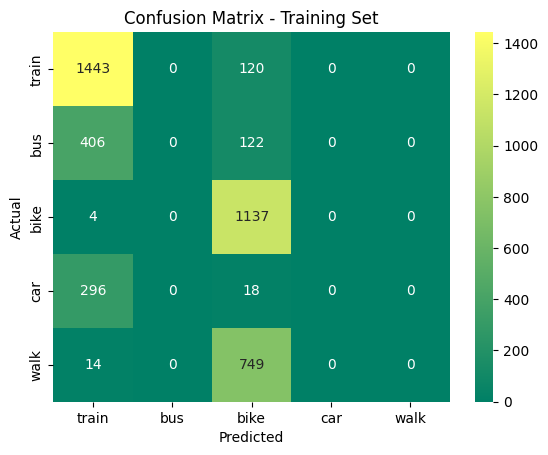

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       train       0.67      0.92      0.77      1563
         bus       0.00      0.00      0.00       528
        bike       0.53      1.00      0.69      1141
         car       0.00      0.00      0.00       314
        walk       0.00      0.00      0.00       763

    accuracy                           0.60      4309
   macro avg       0.24      0.38      0.29      4309
weighted avg       0.38      0.60      0.46      4309


Test Accuracy: 0.59


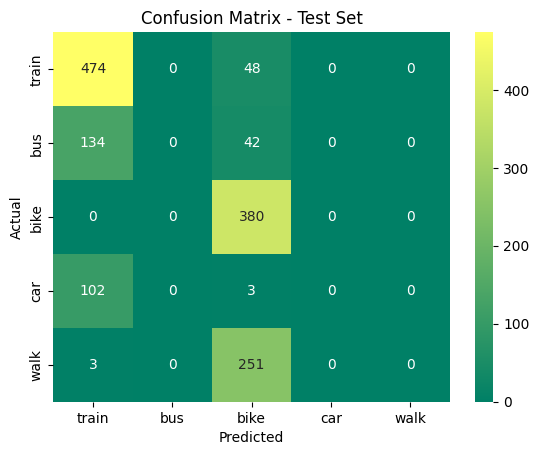

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       train       0.66      0.91      0.77       522
         bus       0.00      0.00      0.00       176
        bike       0.52      1.00      0.69       380
         car       0.00      0.00      0.00       105
        walk       0.00      0.00      0.00       254

    accuracy                           0.59      1437
   macro avg       0.24      0.38      0.29      1437
weighted avg       0.38      0.59      0.46      1437

This model has a max depth of 2
This model took 0.2658085823059082 seconds to train
Training Accuracy: 0.79


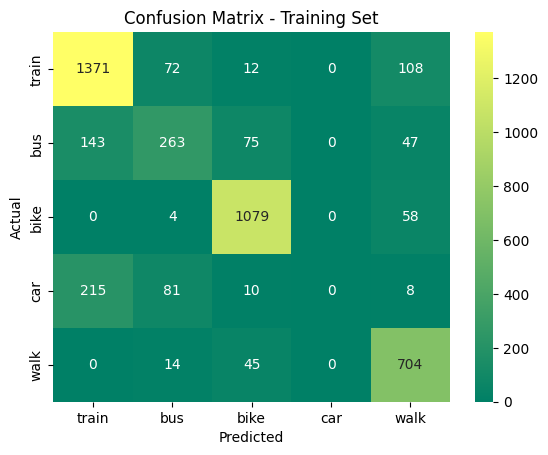

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       train       0.79      0.88      0.83      1563
         bus       0.61      0.50      0.55       528
        bike       0.88      0.95      0.91      1141
         car       0.00      0.00      0.00       314
        walk       0.76      0.92      0.83       763

    accuracy                           0.79      4309
   macro avg       0.61      0.65      0.63      4309
weighted avg       0.73      0.79      0.76      4309


Test Accuracy: 0.78


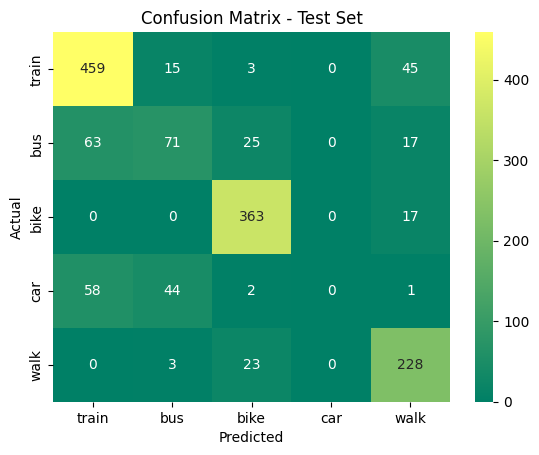

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       train       0.79      0.88      0.83       522
         bus       0.53      0.40      0.46       176
        bike       0.87      0.96      0.91       380
         car       0.00      0.00      0.00       105
        walk       0.74      0.90      0.81       254

    accuracy                           0.78      1437
   macro avg       0.59      0.63      0.60      1437
weighted avg       0.71      0.78      0.74      1437

This model has a max depth of 3
This model took 0.4043419361114502 seconds to train
Training Accuracy: 0.81


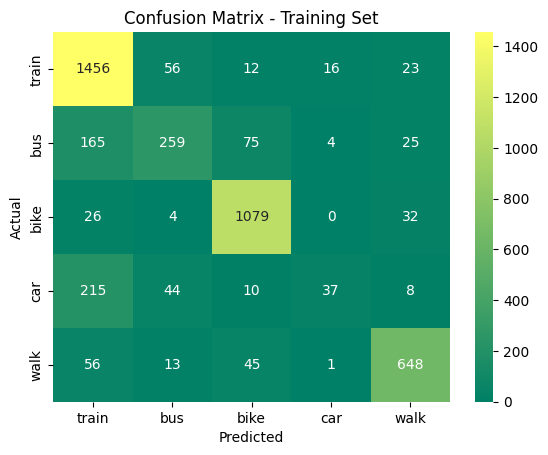

              precision    recall  f1-score   support

       train       0.76      0.93      0.84      1563
         bus       0.69      0.49      0.57       528
        bike       0.88      0.95      0.91      1141
         car       0.64      0.12      0.20       314
        walk       0.88      0.85      0.86       763

    accuracy                           0.81      4309
   macro avg       0.77      0.67      0.68      4309
weighted avg       0.80      0.81      0.78      4309


Test Accuracy: 0.80


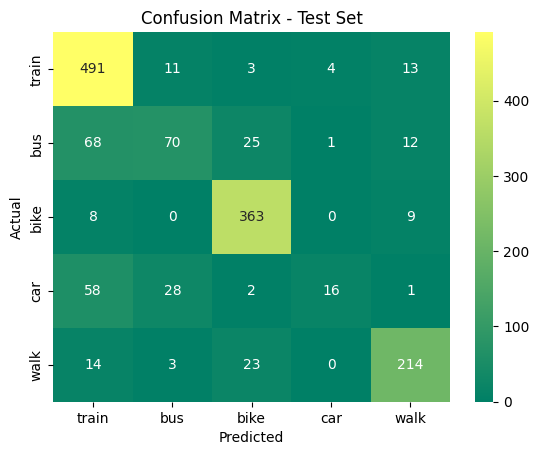

              precision    recall  f1-score   support

       train       0.77      0.94      0.85       522
         bus       0.62      0.40      0.49       176
        bike       0.87      0.96      0.91       380
         car       0.76      0.15      0.25       105
        walk       0.86      0.84      0.85       254

    accuracy                           0.80      1437
   macro avg       0.78      0.66      0.67      1437
weighted avg       0.79      0.80      0.78      1437

This model has a max depth of 4
This model took 0.24260187149047852 seconds to train
Training Accuracy: 0.82


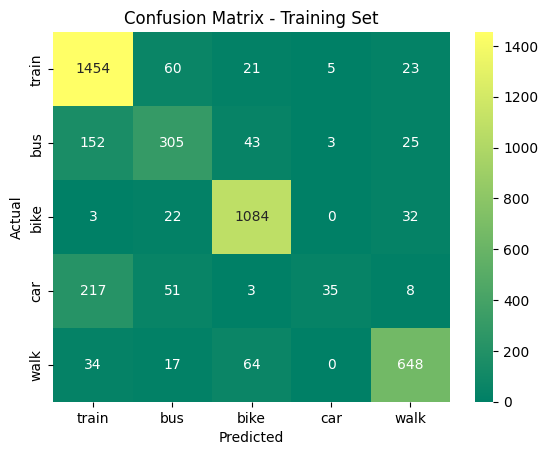

              precision    recall  f1-score   support

       train       0.78      0.93      0.85      1563
         bus       0.67      0.58      0.62       528
        bike       0.89      0.95      0.92      1141
         car       0.81      0.11      0.20       314
        walk       0.88      0.85      0.86       763

    accuracy                           0.82      4309
   macro avg       0.81      0.68      0.69      4309
weighted avg       0.82      0.82      0.80      4309


Test Accuracy: 0.80


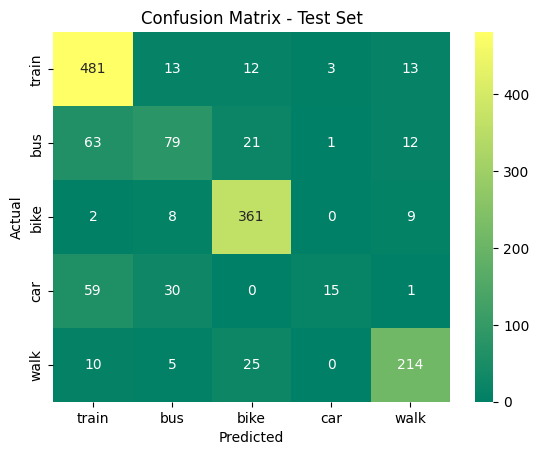

              precision    recall  f1-score   support

       train       0.78      0.92      0.85       522
         bus       0.59      0.45      0.51       176
        bike       0.86      0.95      0.90       380
         car       0.79      0.14      0.24       105
        walk       0.86      0.84      0.85       254

    accuracy                           0.80      1437
   macro avg       0.78      0.66      0.67      1437
weighted avg       0.79      0.80      0.78      1437

This model has a max depth of 5
This model took 0.18360424041748047 seconds to train
Training Accuracy: 0.83


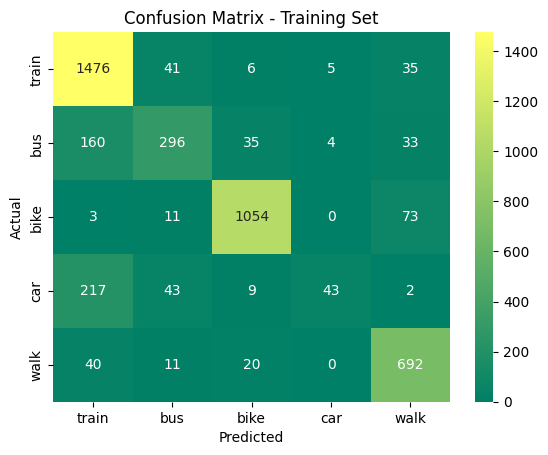

              precision    recall  f1-score   support

       train       0.78      0.94      0.85      1563
         bus       0.74      0.56      0.64       528
        bike       0.94      0.92      0.93      1141
         car       0.83      0.14      0.23       314
        walk       0.83      0.91      0.87       763

    accuracy                           0.83      4309
   macro avg       0.82      0.69      0.70      4309
weighted avg       0.83      0.83      0.80      4309


Test Accuracy: 0.80


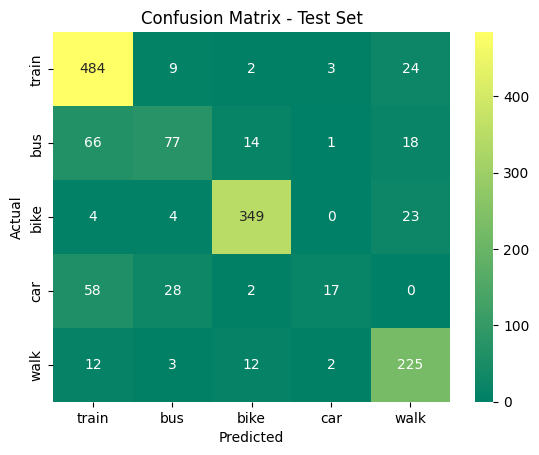

              precision    recall  f1-score   support

       train       0.78      0.93      0.84       522
         bus       0.64      0.44      0.52       176
        bike       0.92      0.92      0.92       380
         car       0.74      0.16      0.27       105
        walk       0.78      0.89      0.83       254

    accuracy                           0.80      1437
   macro avg       0.77      0.67      0.68      1437
weighted avg       0.79      0.80      0.78      1437

This model has a max depth of 6
This model took 0.21387243270874023 seconds to train
Training Accuracy: 0.85


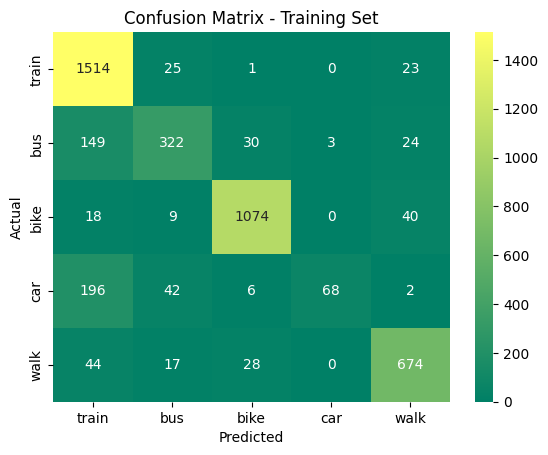

              precision    recall  f1-score   support

       train       0.79      0.97      0.87      1563
         bus       0.78      0.61      0.68       528
        bike       0.94      0.94      0.94      1141
         car       0.96      0.22      0.35       314
        walk       0.88      0.88      0.88       763

    accuracy                           0.85      4309
   macro avg       0.87      0.72      0.75      4309
weighted avg       0.86      0.85      0.83      4309


Test Accuracy: 0.81


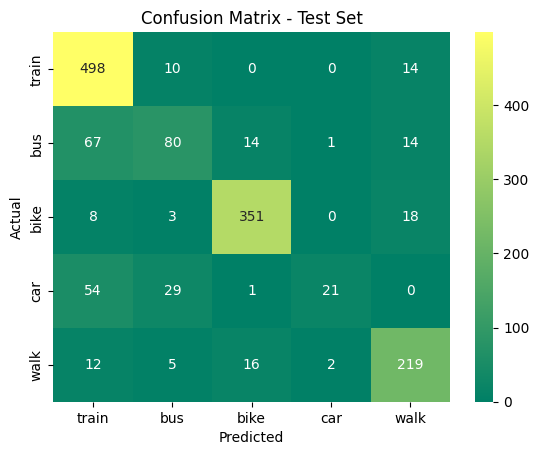

              precision    recall  f1-score   support

       train       0.78      0.95      0.86       522
         bus       0.63      0.45      0.53       176
        bike       0.92      0.92      0.92       380
         car       0.88      0.20      0.33       105
        walk       0.83      0.86      0.84       254

    accuracy                           0.81      1437
   macro avg       0.81      0.68      0.70      1437
weighted avg       0.81      0.81      0.79      1437

This model has a max depth of 7
This model took 0.23233962059020996 seconds to train
Training Accuracy: 0.87


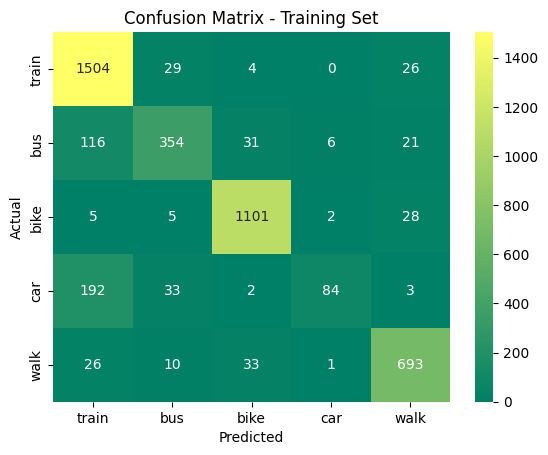

              precision    recall  f1-score   support

       train       0.82      0.96      0.88      1563
         bus       0.82      0.67      0.74       528
        bike       0.94      0.96      0.95      1141
         car       0.90      0.27      0.41       314
        walk       0.90      0.91      0.90       763

    accuracy                           0.87      4309
   macro avg       0.88      0.75      0.78      4309
weighted avg       0.87      0.87      0.85      4309


Test Accuracy: 0.82


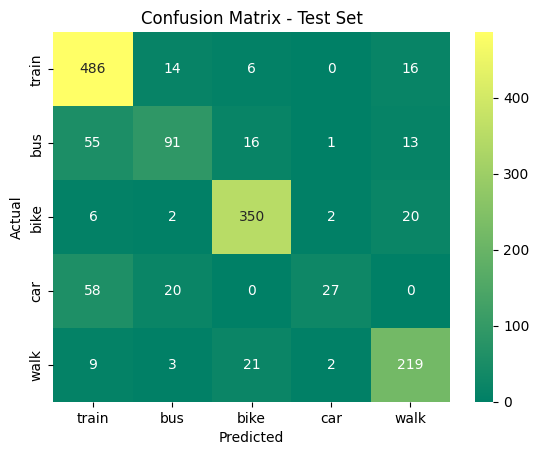

              precision    recall  f1-score   support

       train       0.79      0.93      0.86       522
         bus       0.70      0.52      0.59       176
        bike       0.89      0.92      0.91       380
         car       0.84      0.26      0.39       105
        walk       0.82      0.86      0.84       254

    accuracy                           0.82      1437
   macro avg       0.81      0.70      0.72      1437
weighted avg       0.81      0.82      0.80      1437

This model has a max depth of 8
This model took 0.25865626335144043 seconds to train
Training Accuracy: 0.89


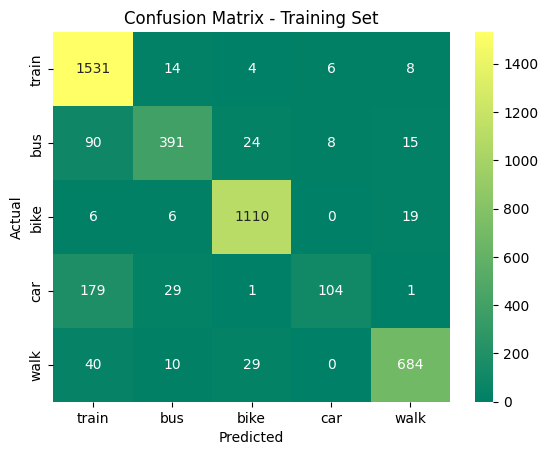

              precision    recall  f1-score   support

       train       0.83      0.98      0.90      1563
         bus       0.87      0.74      0.80       528
        bike       0.95      0.97      0.96      1141
         car       0.88      0.33      0.48       314
        walk       0.94      0.90      0.92       763

    accuracy                           0.89      4309
   macro avg       0.89      0.78      0.81      4309
weighted avg       0.89      0.89      0.88      4309


Test Accuracy: 0.81


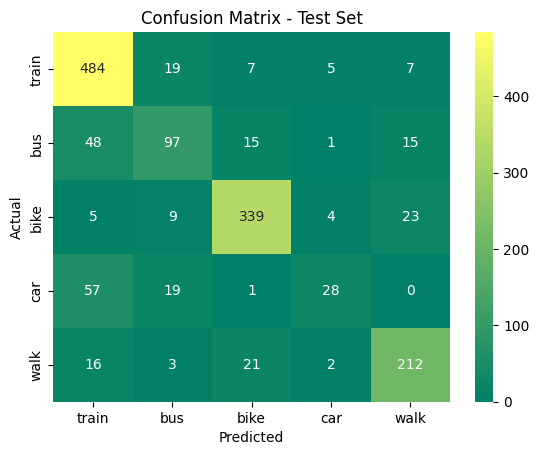

              precision    recall  f1-score   support

       train       0.79      0.93      0.86       522
         bus       0.66      0.55      0.60       176
        bike       0.89      0.89      0.89       380
         car       0.70      0.27      0.39       105
        walk       0.82      0.83      0.83       254

    accuracy                           0.81      1437
   macro avg       0.77      0.69      0.71      1437
weighted avg       0.80      0.81      0.79      1437

This model has a max depth of 9
This model took 0.2709465026855469 seconds to train
Training Accuracy: 0.91


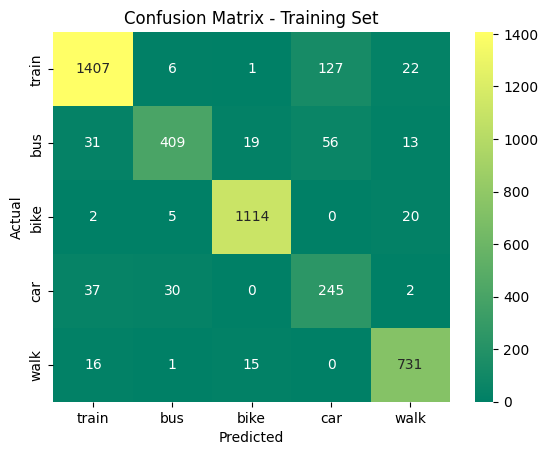

              precision    recall  f1-score   support

       train       0.94      0.90      0.92      1563
         bus       0.91      0.77      0.84       528
        bike       0.97      0.98      0.97      1141
         car       0.57      0.78      0.66       314
        walk       0.93      0.96      0.94       763

    accuracy                           0.91      4309
   macro avg       0.86      0.88      0.87      4309
weighted avg       0.92      0.91      0.91      4309


Test Accuracy: 0.80


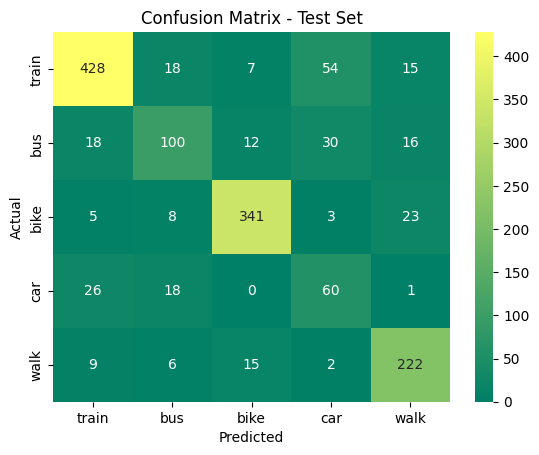

              precision    recall  f1-score   support

       train       0.88      0.82      0.85       522
         bus       0.67      0.57      0.61       176
        bike       0.91      0.90      0.90       380
         car       0.40      0.57      0.47       105
        walk       0.80      0.87      0.84       254

    accuracy                           0.80      1437
   macro avg       0.73      0.75      0.73      1437
weighted avg       0.81      0.80      0.80      1437

This model has a max depth of 10
This model took 0.28441596031188965 seconds to train
Training Accuracy: 0.93


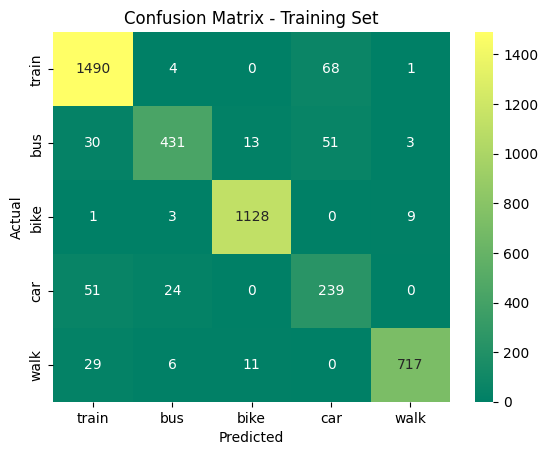

              precision    recall  f1-score   support

       train       0.93      0.95      0.94      1563
         bus       0.92      0.82      0.87       528
        bike       0.98      0.99      0.98      1141
         car       0.67      0.76      0.71       314
        walk       0.98      0.94      0.96       763

    accuracy                           0.93      4309
   macro avg       0.90      0.89      0.89      4309
weighted avg       0.93      0.93      0.93      4309


Test Accuracy: 0.81


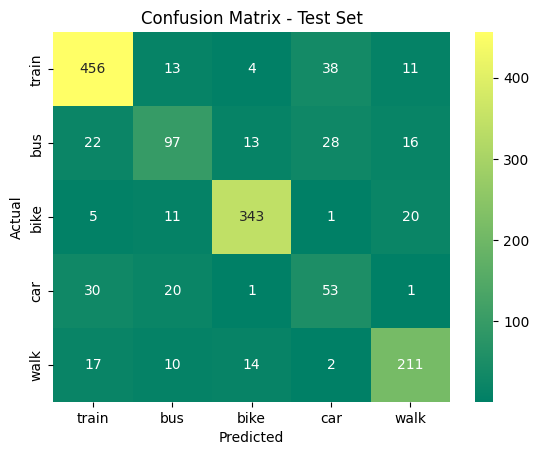

              precision    recall  f1-score   support

       train       0.86      0.87      0.87       522
         bus       0.64      0.55      0.59       176
        bike       0.91      0.90      0.91       380
         car       0.43      0.50      0.47       105
        walk       0.81      0.83      0.82       254

    accuracy                           0.81      1437
   macro avg       0.73      0.73      0.73      1437
weighted avg       0.81      0.81      0.81      1437

This model has a max depth of 11
This model took 0.2912731170654297 seconds to train
Training Accuracy: 0.94


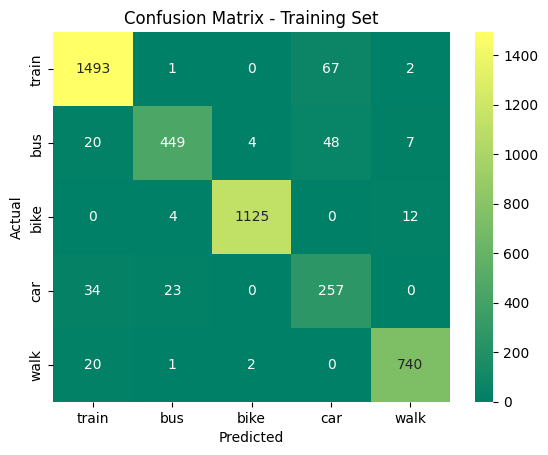

              precision    recall  f1-score   support

       train       0.95      0.96      0.95      1563
         bus       0.94      0.85      0.89       528
        bike       0.99      0.99      0.99      1141
         car       0.69      0.82      0.75       314
        walk       0.97      0.97      0.97       763

    accuracy                           0.94      4309
   macro avg       0.91      0.92      0.91      4309
weighted avg       0.95      0.94      0.94      4309


Test Accuracy: 0.81


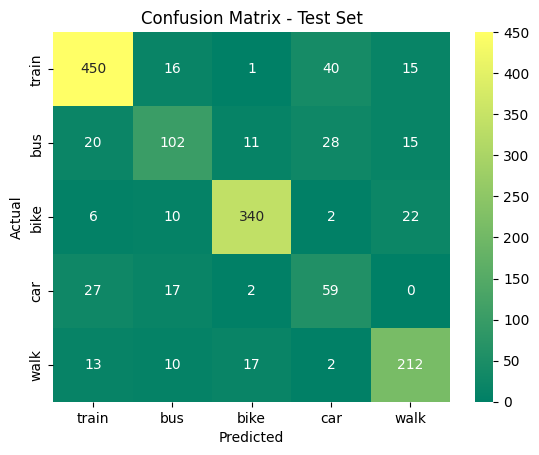

              precision    recall  f1-score   support

       train       0.87      0.86      0.87       522
         bus       0.66      0.58      0.62       176
        bike       0.92      0.89      0.91       380
         car       0.45      0.56      0.50       105
        walk       0.80      0.83      0.82       254

    accuracy                           0.81      1437
   macro avg       0.74      0.75      0.74      1437
weighted avg       0.81      0.81      0.81      1437

This model has a max depth of 12
This model took 0.3038194179534912 seconds to train
Training Accuracy: 0.96


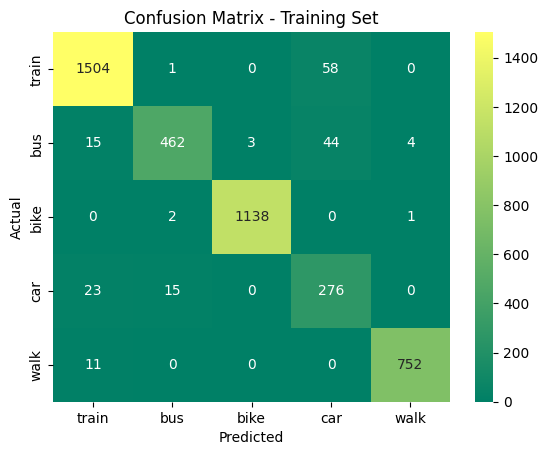

              precision    recall  f1-score   support

       train       0.97      0.96      0.97      1563
         bus       0.96      0.88      0.92       528
        bike       1.00      1.00      1.00      1141
         car       0.73      0.88      0.80       314
        walk       0.99      0.99      0.99       763

    accuracy                           0.96      4309
   macro avg       0.93      0.94      0.93      4309
weighted avg       0.96      0.96      0.96      4309


Test Accuracy: 0.80


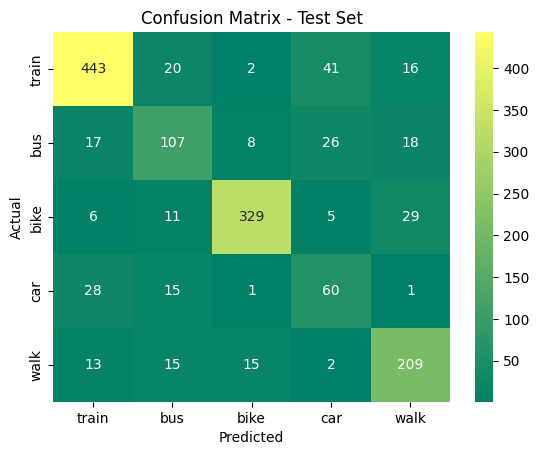

              precision    recall  f1-score   support

       train       0.87      0.85      0.86       522
         bus       0.64      0.61      0.62       176
        bike       0.93      0.87      0.90       380
         car       0.45      0.57      0.50       105
        walk       0.77      0.82      0.79       254

    accuracy                           0.80      1437
   macro avg       0.73      0.74      0.73      1437
weighted avg       0.81      0.80      0.80      1437

This model has a max depth of 13
This model took 0.3222975730895996 seconds to train
Training Accuracy: 0.97


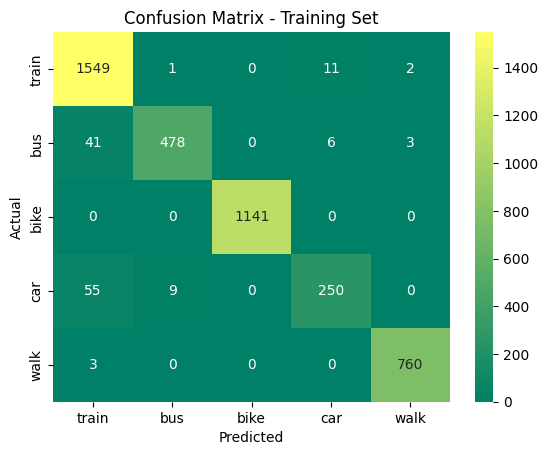

              precision    recall  f1-score   support

       train       0.94      0.99      0.96      1563
         bus       0.98      0.91      0.94       528
        bike       1.00      1.00      1.00      1141
         car       0.94      0.80      0.86       314
        walk       0.99      1.00      0.99       763

    accuracy                           0.97      4309
   macro avg       0.97      0.94      0.95      4309
weighted avg       0.97      0.97      0.97      4309


Test Accuracy: 0.81


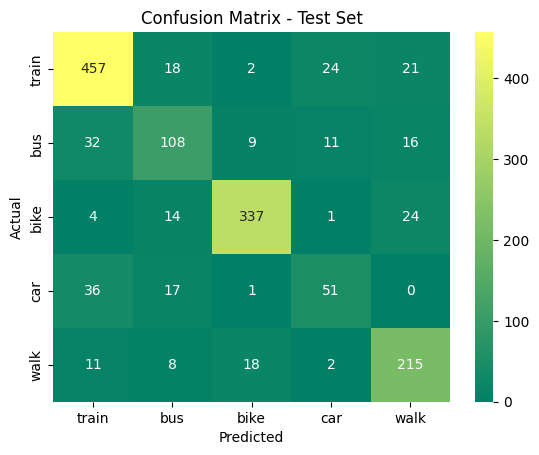

              precision    recall  f1-score   support

       train       0.85      0.88      0.86       522
         bus       0.65      0.61      0.63       176
        bike       0.92      0.89      0.90       380
         car       0.57      0.49      0.53       105
        walk       0.78      0.85      0.81       254

    accuracy                           0.81      1437
   macro avg       0.75      0.74      0.75      1437
weighted avg       0.81      0.81      0.81      1437

This model has a max depth of 14
This model took 0.3041071891784668 seconds to train
Training Accuracy: 0.98


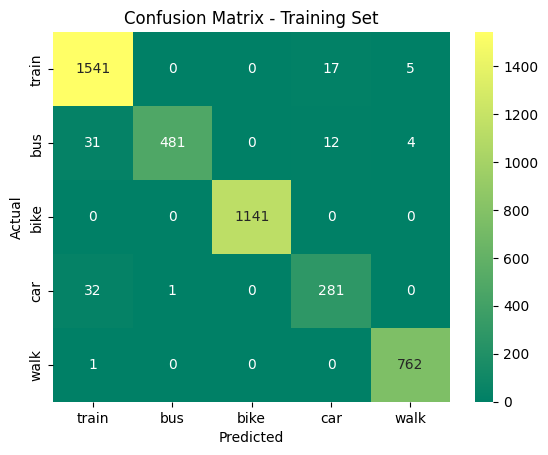

              precision    recall  f1-score   support

       train       0.96      0.99      0.97      1563
         bus       1.00      0.91      0.95       528
        bike       1.00      1.00      1.00      1141
         car       0.91      0.89      0.90       314
        walk       0.99      1.00      0.99       763

    accuracy                           0.98      4309
   macro avg       0.97      0.96      0.96      4309
weighted avg       0.98      0.98      0.98      4309


Test Accuracy: 0.81


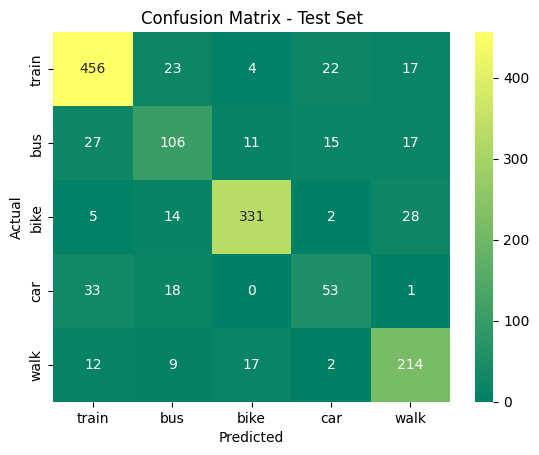

              precision    recall  f1-score   support

       train       0.86      0.87      0.86       522
         bus       0.62      0.60      0.61       176
        bike       0.91      0.87      0.89       380
         car       0.56      0.50      0.53       105
        walk       0.77      0.84      0.81       254

    accuracy                           0.81      1437
   macro avg       0.75      0.74      0.74      1437
weighted avg       0.81      0.81      0.81      1437

This model has a max depth of 15
This model took 0.45200395584106445 seconds to train
Training Accuracy: 0.98


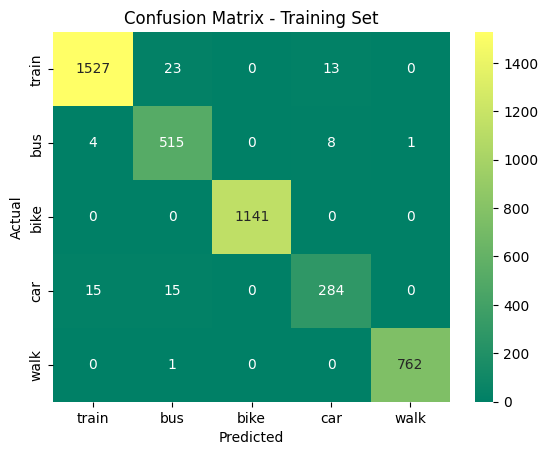

              precision    recall  f1-score   support

       train       0.99      0.98      0.98      1563
         bus       0.93      0.98      0.95       528
        bike       1.00      1.00      1.00      1141
         car       0.93      0.90      0.92       314
        walk       1.00      1.00      1.00       763

    accuracy                           0.98      4309
   macro avg       0.97      0.97      0.97      4309
weighted avg       0.98      0.98      0.98      4309


Test Accuracy: 0.81


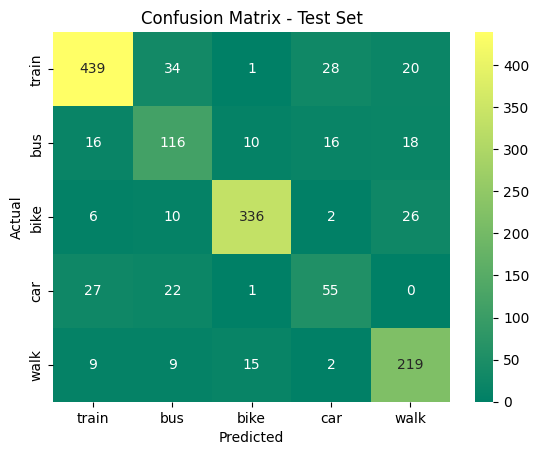

              precision    recall  f1-score   support

       train       0.88      0.84      0.86       522
         bus       0.61      0.66      0.63       176
        bike       0.93      0.88      0.90       380
         car       0.53      0.52      0.53       105
        walk       0.77      0.86      0.82       254

    accuracy                           0.81      1437
   macro avg       0.74      0.75      0.75      1437
weighted avg       0.82      0.81      0.81      1437

This model has a max depth of 16
This model took 0.483628511428833 seconds to train
Training Accuracy: 0.99


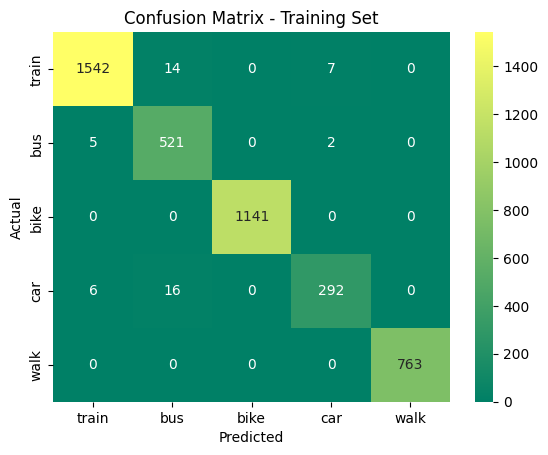

              precision    recall  f1-score   support

       train       0.99      0.99      0.99      1563
         bus       0.95      0.99      0.97       528
        bike       1.00      1.00      1.00      1141
         car       0.97      0.93      0.95       314
        walk       1.00      1.00      1.00       763

    accuracy                           0.99      4309
   macro avg       0.98      0.98      0.98      4309
weighted avg       0.99      0.99      0.99      4309


Test Accuracy: 0.81


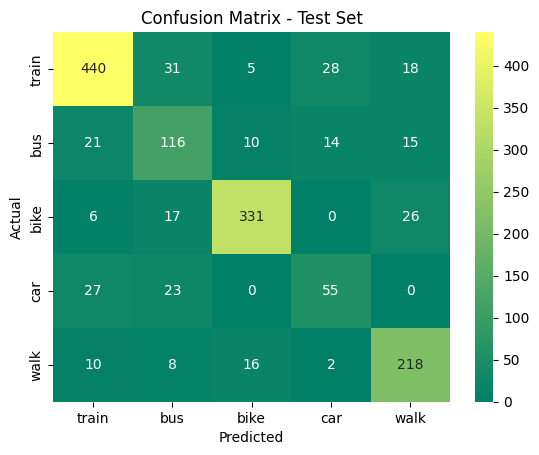

              precision    recall  f1-score   support

       train       0.87      0.84      0.86       522
         bus       0.59      0.66      0.63       176
        bike       0.91      0.87      0.89       380
         car       0.56      0.52      0.54       105
        walk       0.79      0.86      0.82       254

    accuracy                           0.81      1437
   macro avg       0.74      0.75      0.75      1437
weighted avg       0.81      0.81      0.81      1437

This model has a max depth of 17
This model took 0.46227049827575684 seconds to train
Training Accuracy: 0.99


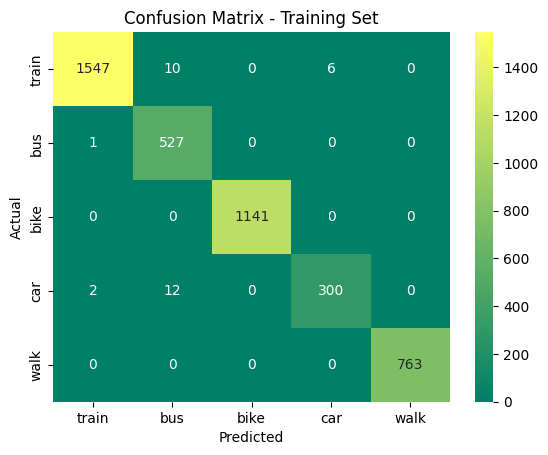

              precision    recall  f1-score   support

       train       1.00      0.99      0.99      1563
         bus       0.96      1.00      0.98       528
        bike       1.00      1.00      1.00      1141
         car       0.98      0.96      0.97       314
        walk       1.00      1.00      1.00       763

    accuracy                           0.99      4309
   macro avg       0.99      0.99      0.99      4309
weighted avg       0.99      0.99      0.99      4309


Test Accuracy: 0.81


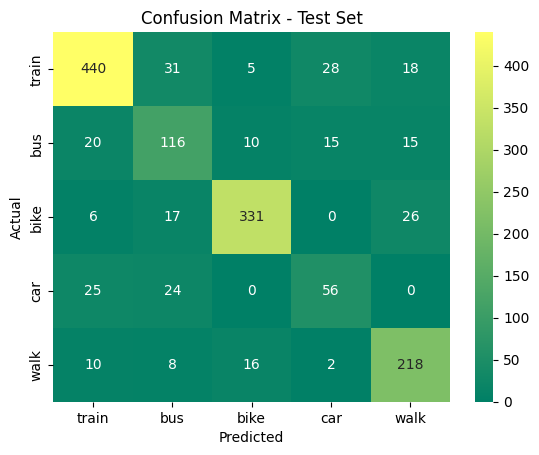

              precision    recall  f1-score   support

       train       0.88      0.84      0.86       522
         bus       0.59      0.66      0.62       176
        bike       0.91      0.87      0.89       380
         car       0.55      0.53      0.54       105
        walk       0.79      0.86      0.82       254

    accuracy                           0.81      1437
   macro avg       0.75      0.75      0.75      1437
weighted avg       0.81      0.81      0.81      1437

This model has a max depth of 18
This model took 0.46915340423583984 seconds to train
Training Accuracy: 0.99


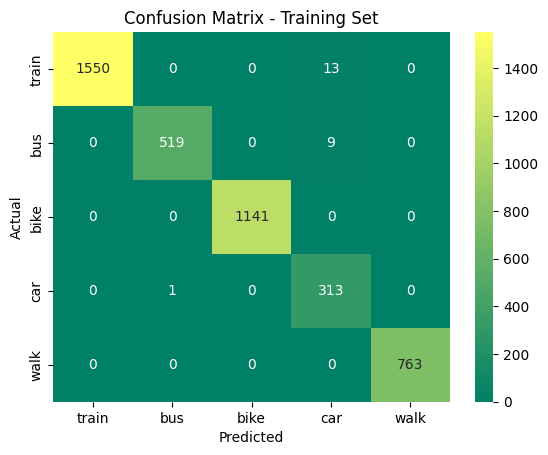

              precision    recall  f1-score   support

       train       1.00      0.99      1.00      1563
         bus       1.00      0.98      0.99       528
        bike       1.00      1.00      1.00      1141
         car       0.93      1.00      0.96       314
        walk       1.00      1.00      1.00       763

    accuracy                           0.99      4309
   macro avg       0.99      0.99      0.99      4309
weighted avg       0.99      0.99      0.99      4309


Test Accuracy: 0.81


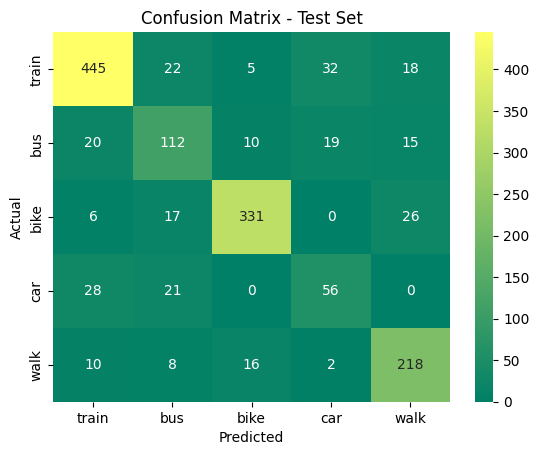

              precision    recall  f1-score   support

       train       0.87      0.85      0.86       522
         bus       0.62      0.64      0.63       176
        bike       0.91      0.87      0.89       380
         car       0.51      0.53      0.52       105
        walk       0.79      0.86      0.82       254

    accuracy                           0.81      1437
   macro avg       0.74      0.75      0.75      1437
weighted avg       0.81      0.81      0.81      1437

This model has a max depth of 19
This model took 0.46701836585998535 seconds to train
Training Accuracy: 1.00


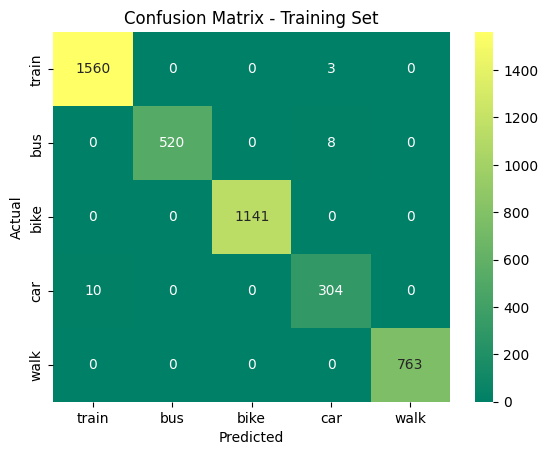

              precision    recall  f1-score   support

       train       0.99      1.00      1.00      1563
         bus       1.00      0.98      0.99       528
        bike       1.00      1.00      1.00      1141
         car       0.97      0.97      0.97       314
        walk       1.00      1.00      1.00       763

    accuracy                           1.00      4309
   macro avg       0.99      0.99      0.99      4309
weighted avg       1.00      1.00      1.00      4309


Test Accuracy: 0.81


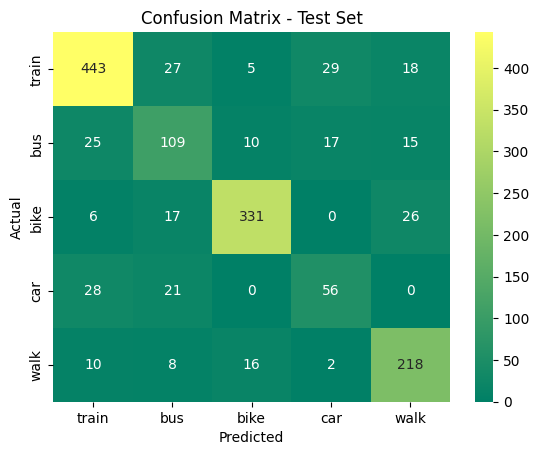

              precision    recall  f1-score   support

       train       0.87      0.85      0.86       522
         bus       0.60      0.62      0.61       176
        bike       0.91      0.87      0.89       380
         car       0.54      0.53      0.54       105
        walk       0.79      0.86      0.82       254

    accuracy                           0.81      1437
   macro avg       0.74      0.75      0.74      1437
weighted avg       0.81      0.81      0.81      1437

This model has a max depth of 20
This model took 0.47235584259033203 seconds to train
Training Accuracy: 1.00


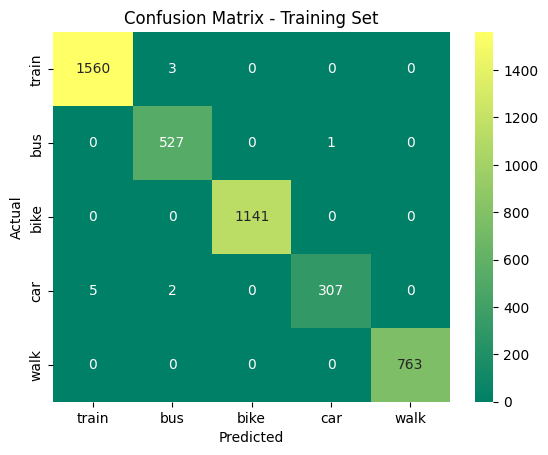

              precision    recall  f1-score   support

       train       1.00      1.00      1.00      1563
         bus       0.99      1.00      0.99       528
        bike       1.00      1.00      1.00      1141
         car       1.00      0.98      0.99       314
        walk       1.00      1.00      1.00       763

    accuracy                           1.00      4309
   macro avg       1.00      0.99      1.00      4309
weighted avg       1.00      1.00      1.00      4309


Test Accuracy: 0.81


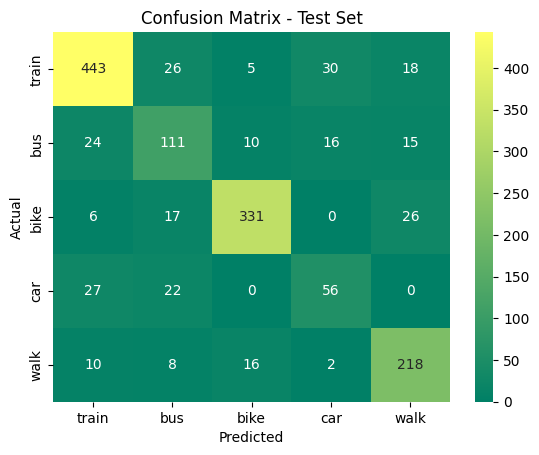

              precision    recall  f1-score   support

       train       0.87      0.85      0.86       522
         bus       0.60      0.63      0.62       176
        bike       0.91      0.87      0.89       380
         car       0.54      0.53      0.54       105
        walk       0.79      0.86      0.82       254

    accuracy                           0.81      1437
   macro avg       0.74      0.75      0.74      1437
weighted avg       0.81      0.81      0.81      1437



In [ ]:
features = derived_motion_features + range_counts_features

for i in range(1, 21):
  train_and_evaluate_decision_tree(df, features, i)

### hide

This model has a max depth of 12
This model took 0.07578659057617188 seconds to train
Training Accuracy: 0.94


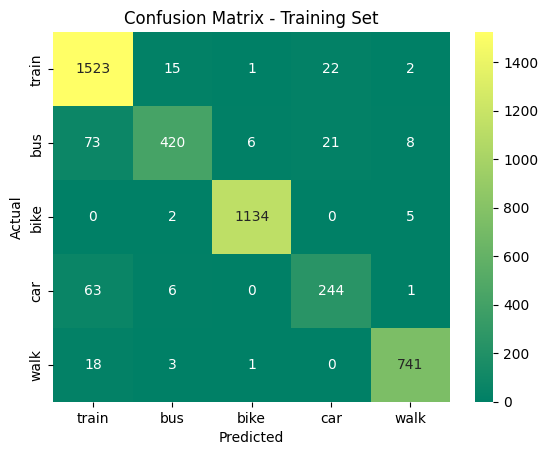

              precision    recall  f1-score   support

       train       0.91      0.97      0.94      1563
         bus       0.94      0.80      0.86       528
        bike       0.99      0.99      0.99      1141
         car       0.85      0.78      0.81       314
        walk       0.98      0.97      0.98       763

    accuracy                           0.94      4309
   macro avg       0.93      0.90      0.92      4309
weighted avg       0.94      0.94      0.94      4309


Test Accuracy: 0.78


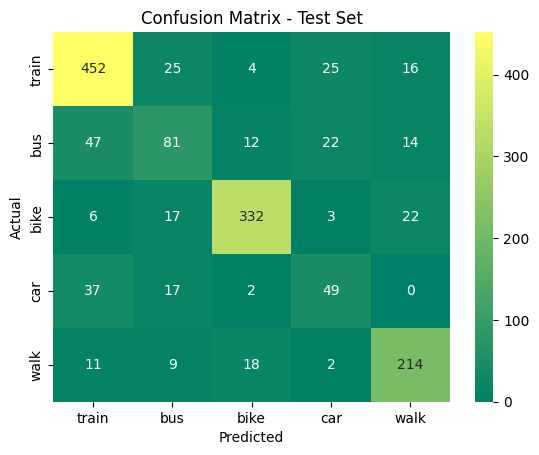

              precision    recall  f1-score   support

       train       0.82      0.87      0.84       522
         bus       0.54      0.46      0.50       176
        bike       0.90      0.87      0.89       380
         car       0.49      0.47      0.48       105
        walk       0.80      0.84      0.82       254

    accuracy                           0.78      1437
   macro avg       0.71      0.70      0.71      1437
weighted avg       0.78      0.78      0.78      1437



In [ ]:
features = range_counts_features
train_and_evaluate_decision_tree(df, features, 12)

### hide

This model has a max depth of 61
This model took 0.07358908653259277 seconds to train
Training Accuracy: 1.00


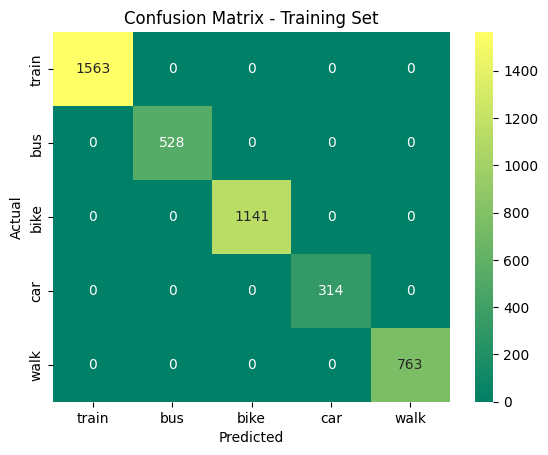

              precision    recall  f1-score   support

       train       1.00      1.00      1.00      1563
         bus       1.00      1.00      1.00       528
        bike       1.00      1.00      1.00      1141
         car       1.00      1.00      1.00       314
        walk       1.00      1.00      1.00       763

    accuracy                           1.00      4309
   macro avg       1.00      1.00      1.00      4309
weighted avg       1.00      1.00      1.00      4309


Test Accuracy: 0.77


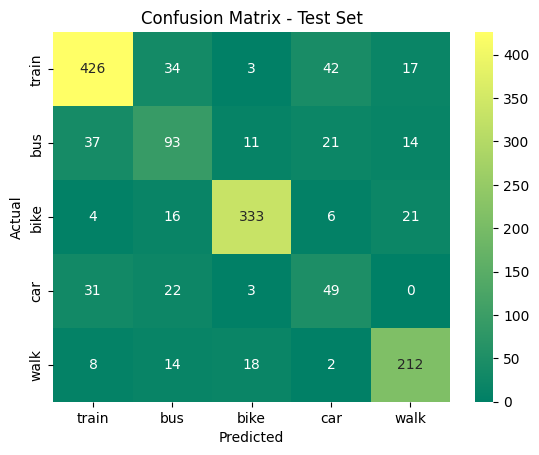

              precision    recall  f1-score   support

       train       0.84      0.82      0.83       522
         bus       0.52      0.53      0.52       176
        bike       0.90      0.88      0.89       380
         car       0.41      0.47      0.44       105
        walk       0.80      0.83      0.82       254

    accuracy                           0.77      1437
   macro avg       0.70      0.70      0.70      1437
weighted avg       0.78      0.77      0.78      1437



In [ ]:
features = range_counts_features
train_and_evaluate_decision_tree(df, features, motion_points)